In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import mpld3
import seaborn as sn
import imp
import os
from collections import defaultdict
from scipy.stats import theilslopes
sn.set_context('notebook')

# ICPW climate trends

This notebook follows on from *icpw_climate_data_proc_py32.ipynb*, which can be found [here](http://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/icpw_climate_data_proc_py32.ipynb). That notebook extracted point time series with annual frequency from CRU netCDF files. The aim of this notebook is to calculate trends and summaries based on these series.

 * For the period from 1990 to 2012, calculate: <br><br>
 
   * The average of annual average temperature and total precipitation <br><br>
   
   * The average of summer (JJA) average temperature and total precipitation <br><br>
   
   * The average of summer (JAS) average temperature and total precipitation <br><br>

 * In addition, for the time periods 1990 to 2012, 1990 to 2004 and 1998 to 2012, calculate: <br><br>
 
   * Trends in the above 6 quantities over the duration of the time period of interest, estimated using the Theil-Sen method <br><br>
   
   * Trend significance for the above 6 quantities estimated using the Mann-Kendall method
   
 Note that the mean temperature estimates should all be corrected for the difference between pixel elevation and actual site elevation according to the **lapse rate**. The actual lapse rate is highly variable, but Heleen would like to use a value of 0.6C/100m (see e-mail received 23/01/2017 at 11.49).
 
**To do:** Heleen would also like to add a fourth time period (1990 to 1992) to the trends analysis. For this period we are only interested in median TOC, ECa_EMg and ECaX_EMgX. I haven't done this yet as time is very tight, and it's probably easier to do separately anyway. **Come back to this**.

## 1. Calculate trends

The code below calculates all the desired statistics.

In [2]:
# Import my earlier code for the M-K test
resa2_trends_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
                     r'\Python\icpw\toc_trends_analysis.py')

resa2_trends = imp.load_source('toc_trends_analysis', resa2_trends_path)

In [3]:
# Define variables and periods of interest
var_list = ['pre', 'tmp']
per_list = [[1990, 2012], [1990, 2004], [1998, 2012]]

# Excel file of climate data and stn elevs
clim_xls = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
            r'\CRU_Climate_Data\cru_climate_summaries.xlsx')

stn_xls = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
           r'\CRU_Climate_Data\cru_stn_elevs.csv')

# Output summary stats
out_csv = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
           r'\CRU_Climate_Data\icpw_climate_stats.csv')

# Output folder for plots
plot_fold = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\TOC_Trends_Analysis_2015'
             r'\CRU_Climate_Data\plots')

# Produce plots? (For testing)
make_plots = False

In [4]:
# Read stn elev data
stn_df = pd.read_csv(stn_xls)

# Get list of sites
stn_list = stn_df['stn_id'].unique()

# Dict to store output
data_dict = defaultdict(list)

# Loop over data
for var in var_list:
    for tm in ['ann', 'jja', 'jas']:
        # Open the climate data
        clim_df = pd.read_excel(clim_xls, sheetname='%s_%s' % (var, tm))
        
        # Loop over stations
        for stn in stn_list:
            # Filter the climate data for this station
            stn_clim_df = clim_df.query('stn_id == @stn')
            
            # Set date index
            stn_clim_df.index = stn_clim_df['time']
            del stn_clim_df['time']
            stn_clim_df = stn_clim_df.sort_index()
            
            # Correct temperatures according to lapse rate
            if var == 'tmp':
                # Get elevations
                stn_elev = stn_df.query('stn_id == @stn')['elev_m'].values[0]
                px_elev = stn_df.query('stn_id == @stn')['px_elev_m'].values[0]
                
                # If pixel elev is negative (i.e. in sea), correct back to s.l.
                if px_elev < 0:
                    px_elev = 0
                
                # Calculate temperature difference based on 0.6C/100m
                t_diff = 0.6 * (px_elev - stn_elev) / 100.
                
                # Apply correction
                stn_clim_df['tmp'] = stn_clim_df['tmp'] + t_diff
            
            # Loop over time periods
            for per in per_list:
                # Truncate
                df = stn_clim_df.truncate(before='%s-01-01' % per[0],
                                          after='%s-12-31' % per[1])

                # Only need averages for 1990-2012
                if (per[0]==1990) and (per[1]==2012):
                    # Calculate long-term averages
                    key = '%s_%s_%s-%s_avg' % (var, tm, per[0], per[1])
                    val = df.mean()[var]
                    data_dict[key].append(val)
                
                # Calculate Sen's slope and add to dict
                sslp, icpt, lb, ub = theilslopes(df[var].values, 
                                                 df['year'], 0.95)
                
                key = '%s_%s_%s-%s_slp' % (var, tm, per[0], per[1])
                data_dict[key].append(sslp)
                
                # Calculate MK signif and add to dict
                res = resa2_trends.mk_test(df[var].values, str(stn), var)
                sig = res[3]
                
                key = '%s_%s_%s-%s_sig' % (var, tm, per[0], per[1])
                data_dict[key].append(sig)
                
                # Plot
                if make_plots:
                    plt.plot(df['year'], df[var].values, 'bo-')
                    plt.plot(df['year'],
                             sslp*df['year'] + icpt,
                             'k-')
                    plt.title('%s %s at station %s (%s-%s)' % (tm, var, stn, per[0], per[1]),
                              fontsize=20)

                    # Save
                    png_path = os.path.join(plot_fold, 
                                            '%s_%s_%s_%s-%s.png' % (stn, tm, var, 
                                                                    per[0], per[1]))
                    plt.savefig(png_path, dpi=150)
                    plt.close()

# Build output df
df = pd.DataFrame(data_dict, index=stn_list)

# Reorder columns
cols = df.columns
cols = sorted(cols)
df = df[cols]

# Save
df.to_csv(out_csv, index_label='stn_id')

df.head()

,pre_ann_1990-2004_sig,pre_ann_1990-2004_slp,pre_ann_1990-2012_avg,pre_ann_1990-2012_sig,pre_ann_1990-2012_slp,pre_ann_1998-2012_sig,pre_ann_1998-2012_slp,pre_jas_1990-2004_sig,pre_jas_1990-2004_slp,pre_jas_1990-2012_avg,...,tmp_jas_1990-2012_slp,tmp_jas_1998-2012_sig,tmp_jas_1998-2012_slp,tmp_jja_1990-2004_sig,tmp_jja_1990-2004_slp,tmp_jja_1990-2012_avg,tmp_jja_1990-2012_sig,tmp_jja_1990-2012_slp,tmp_jja_1998-2012_sig,tmp_jja_1998-2012_slp
23469,0.428480,6.642857,721.121739,0.634510,1.730769,0.552615,-3.872727,1.000000,-0.575000,260.517391,...,0.024444,0.399612,-0.033333,0.585735,0.027273,17.595565,0.957845,0.003333,1.000000,0.000000
23459,0.234955,-9.857143,1531.613043,0.459608,5.566667,0.373053,8.266667,0.373053,-4.050000,437.508696,...,0.052941,0.275100,0.047619,0.321112,-0.041667,13.876580,0.653108,0.012821,0.346495,0.033333
23468,0.428480,6.642857,721.121739,0.634510,1.730769,0.552615,-3.872727,1.000000,-0.575000,260.517391,...,0.024444,0.399612,-0.033333,0.585735,0.027273,17.715565,0.957845,0.003333,1.000000,0.000000
23455,0.165857,-15.425000,1086.830435,0.153821,-5.083333,0.620691,6.300000,0.276278,-4.357143,296.600000,...,0.077273,0.766525,0.008333,0.585735,0.052381,16.498928,0.090526,0.069048,0.427346,0.053333
23460,0.074825,-13.566667,1418.265217,0.561220,2.860000,0.373053,10.570000,0.488422,-2.685714,382.095652,...,0.058824,0.346495,0.036667,0.487354,-0.026667,11.991014,0.368540,0.019048,0.215458,0.044444


## 2. Compare to old climate data

The old climate data was calculated using a much earlier version of the CRU dataset, but it's probably still worth checking to see whether the new values are broadly compatible. The code below reads the old climate data and restructures it.

In [5]:
# Process raw climate data
# File paths
pptn_csv = (r'K:\Prosjekter\langtransporterte forurensninger\O-23300 - ICP-WATERS - HWI'
            r'\Database\2015 DOC analysis\climate data\2016-02-02 from don\Precip_res_NEW_corr.csv')

temp_csv = (r'K:\Prosjekter\langtransporterte forurensninger\O-23300 - ICP-WATERS - HWI'
            r'\Database\2015 DOC analysis\climate data\2016-02-02 from don\Temp_res_NEW_corr.csv')

# Container for DFs
df_list = []

# Loop over files
for csv in [pptn_csv, temp_csv]:
    # Read data
    df = pd.read_csv(csv, delimiter=';')

    # Melt
    df = pd.melt(df, id_vars=['StationID', 'Variable'],
                 var_name='Param', value_name='value')
    
    # Concat 'variable' and 'param' cols
    # Convert to lower case
    df['variable'] = df['Variable'].str.lower() + '_' + df['Param'].str.lower()
    
    # Tidy
    df['station_id'] = df['StationID']
    del df['Param'], df['Variable'], df['StationID']
    
    # Pivot
    df = df.pivot(index='station_id', columns='variable',
                  values='value')
    
    # Add to list
    df_list.append(df)

# Concat pptn and temp data
df = pd.concat(df_list, axis=1)

# Reset index and tidy
df.reset_index(inplace=True)
df.columns.name = None
df.index = df['station_id']
del df['station_id']

df.head()

,precip_jas_lm_pval_90_04,precip_jas_lm_pval_90_12,precip_jas_lm_pval_98_12,precip_jas_lm_slope_90_04,precip_jas_lm_slope_90_12,precip_jas_lm_slope_98_12,precip_jas_manken_pval_90_04,precip_jas_manken_pval_90_12,precip_jas_manken_pval_98_12,precip_jas_senslope90_04,...,temp_yr_lm_pval_98_12,temp_yr_lm_slope_90_04,temp_yr_lm_slope_90_12,temp_yr_lm_slope_98_12,temp_yr_manken_pval_90_04,temp_yr_manken_pval_90_12,temp_yr_manken_pval_98_12,temp_yr_senslope90_04,temp_yr_senslope90_12,temp_yr_senslope98_12
station_id,,,,,,,,,,,,,,,,,,,,,
100,0.325835,0.000240,0.003147,2.503929,7.122036,10.446429,0.766525,0.006020,0.113287,0.350000,...,0.731979,0.030417,0.017762,-0.016012,0.276278,0.204904,0.843085,0.046970,0.038889,0.033333
101,0.685728,0.001986,0.009279,0.941429,5.029051,8.010000,0.692181,0.008265,0.029448,0.775000,...,0.579869,0.028899,0.012467,-0.026905,0.373053,0.267327,0.843085,0.034722,0.029167,0.018333
102,0.647042,0.001862,0.013072,1.148214,5.088933,8.318214,0.346495,0.003980,0.022822,2.077778,...,0.433407,0.021250,0.001952,-0.040744,0.620691,0.443575,1.000000,0.026042,0.025000,-0.006061
103,0.394579,0.000502,0.002914,2.205357,6.711759,10.253214,0.620691,0.015109,0.137646,0.800000,...,0.834824,0.007351,0.009247,-0.009107,1.000000,0.398036,0.620691,0.013333,0.025000,0.027778
104,0.305090,0.000457,0.004516,2.369643,6.359486,9.833929,0.620691,0.005118,0.037667,2.107692,...,0.667430,0.024970,0.013019,-0.020565,0.346495,0.234485,0.843085,0.027083,0.030556,0.025000


In [6]:
# Read the new data again (calculated earlier in this notebook)
new_df = pd.read_csv(out_csv, index_col=0, encoding='utf-8')

# Join
df = new_df.join(df)

Plot a few examples to see how similar the results are.

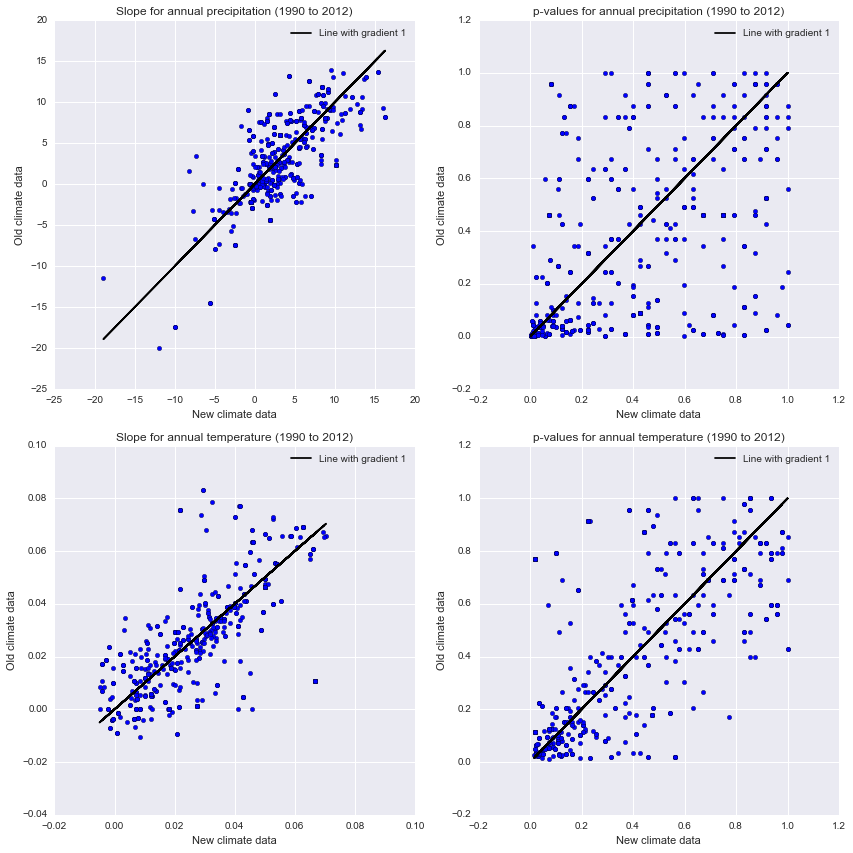

In [7]:
# Compare estimates
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Annual slopes (pptn)
axes[0, 0].scatter(df['pre_ann_1990-2012_slp'], df['precip_yr_senslope90_12'],
                   label='')
axes[0, 0].plot(df['pre_ann_1990-2012_slp'], df['pre_ann_1990-2012_slp'],
                'k-', label='Line with gradient 1')
axes[0, 0].set_title('Slope for annual precipitation (1990 to 2012)')
axes[0, 0].set_xlabel('New climate data')
axes[0, 0].set_ylabel('Old climate data')
axes[0, 0].legend(loc='best')

# Annual slopes p-vals (pptn)
axes[0, 1].scatter(df['pre_ann_1990-2012_sig'], df['precip_yr_manken_pval_90_12'],
                   label='')
axes[0, 1].plot(df['pre_ann_1990-2012_sig'], df['pre_ann_1990-2012_sig'],
                'k-', label='Line with gradient 1')
axes[0, 1].set_title('p-values for annual precipitation (1990 to 2012)')
axes[0, 1].set_xlabel('New climate data')
axes[0, 1].set_ylabel('Old climate data')
axes[0, 1].legend(loc='best')

# Annual slopes (temp)
axes[1, 0].scatter(df['tmp_ann_1990-2012_slp'], df['temp_yr_senslope90_12'],
                   label='')
axes[1, 0].plot(df['tmp_ann_1990-2012_slp'], df['tmp_ann_1990-2012_slp'],
                'k-', label='Line with gradient 1')
axes[1, 0].set_title('Slope for annual temperature (1990 to 2012)')
axes[1, 0].set_xlabel('New climate data')
axes[1, 0].set_ylabel('Old climate data')
axes[1, 0].legend(loc='best')

# Annual slopes p-vals (temp)
axes[1, 1].scatter(df['tmp_ann_1990-2012_sig'], df['temp_yr_manken_pval_90_12'],
                   label='')
axes[1, 1].plot(df['tmp_ann_1990-2012_sig'], df['tmp_ann_1990-2012_sig'],
                'k-', label='Line with gradient 1')
axes[1, 1].set_title('p-values for annual temperature (1990 to 2012)')
axes[1, 1].set_xlabel('New climate data')
axes[1, 1].set_ylabel('Old climate data')
axes[1, 1].legend(loc='best')

plt.tight_layout()

The slope estimates (left column) are not identical, but the values are clearly related and are more-or-less evenly scattered around the 1:1 line. These differences are probably due to changes in the climate data as it has been updated, so I am not too worries about these. 

The p-values, however, seem very different indeed: there is essentially no relationshiop between the values calculated in my script and those obtained in the previous climate analysis. Because the data has changed, I do not expect the p-values to be identical, but I'm a little surprised to see just how different they are.

As a check on my approach, I've manually extracted annual time series for two parameters at two of the sites and then calculated M-K statistics using the the "[trends](ftp://cran.r-project.org/pub/R/web/packages/trend/vignettes/trend.pdf)" package in R. This is a completely independent package from anything in my analysis, and I would expect the R output for something as common as M-K to be pretty reliable. R reports the p-values to 5 decimal places and the results agree *exactly* with the output from my script. I am therefore reasonably confident that my code is correctly estimating significance levels. 

 * What code was used for calculating p-values in the previous analysis? <br><br>
 
 * Was the previous analysis analysing the same quantities/variables (i.e. means of annual means)?